In [1]:
import sys
#!{sys.executable} -m pip install rake_nltk

In [135]:
import json 
with open("../notebooks/B54BU.json", "r") as F:
    data = json.load(F)
print('Have %d extracts' % len(data))
    
from nltk.data import find
from nltk.corpus import stopwords
import gensim
import numpy as np
from scipy import spatial
#reading in vectors database
word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))
model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_sample, binary=False)

#reading in stopwords
S = set(stopwords.words('english'))
with open('../flaskr/static/stopwords.txt','r') as F:
    stopwords = F.readlines()
stopwords = [w.strip() for w in stopwords]
stopwords = S.union(stopwords)



Have 1969 extracts


In [136]:
#filtering based on length
def ngoodwords(doc):
    words = doc.split(' ')
    good = [w for w in words if not w in stopwords]
    return len(good)
    
data = [d for d in data if ngoodwords(d) > 20]
print('Have %d extracts after filtering' % len(data))


Have 1150 extracts after filtering


In [137]:
def norm(vec):
    return np.linalg.norm(vec)

def similarity(vec1, vec2):
    if norm(vec1) < 0.1 or norm(vec2) < 0.1:
        return 0.0
    return 1.0 - spatial.distance.cosine(vec1, vec2)


def doc2vec(doc):
    v = model['house'] - model['house']
    cnt = 0
    for w in doc.split(' '):
        if model.has_index_for(w) and not w in stopwords:
            v += model.get_vector(w)
            cnt += 1
    if cnt > 0:
        v /= norm(v)
    return v

In [138]:
#vectorising all the extracts
docvecs = [doc2vec(doc) for doc in data]

def search(word):
    v = model.get_vector(word)
    scores = [similarity(v,dv) for dv in docvecs]
    idxs = np.argsort(scores)[::-1][:10]
    return [data[i] for i in idxs]


In [139]:
docvecs[0].shape

(300,)

In [140]:
import umap
reducer = umap.UMAP(metric='cosine')
embedding = reducer.fit_transform(docvecs)
embedding.shape

(1150, 2)

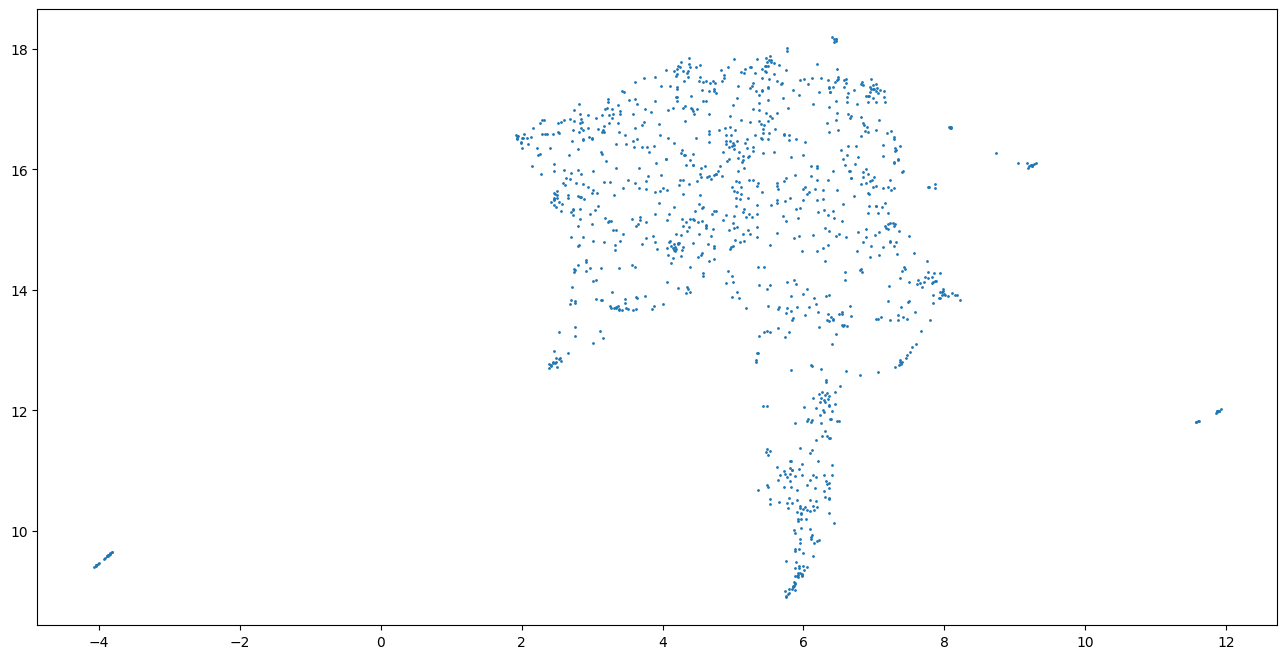

In [141]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    s=1)

In [142]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
sil = []
K = range(2,10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(docvecs)
    labels = kmeans.labels_
    sil.append(silhouette_score(embedding, labels, metric = 'euclidean'))
#pred = kmeans.fit_predict(embedding)

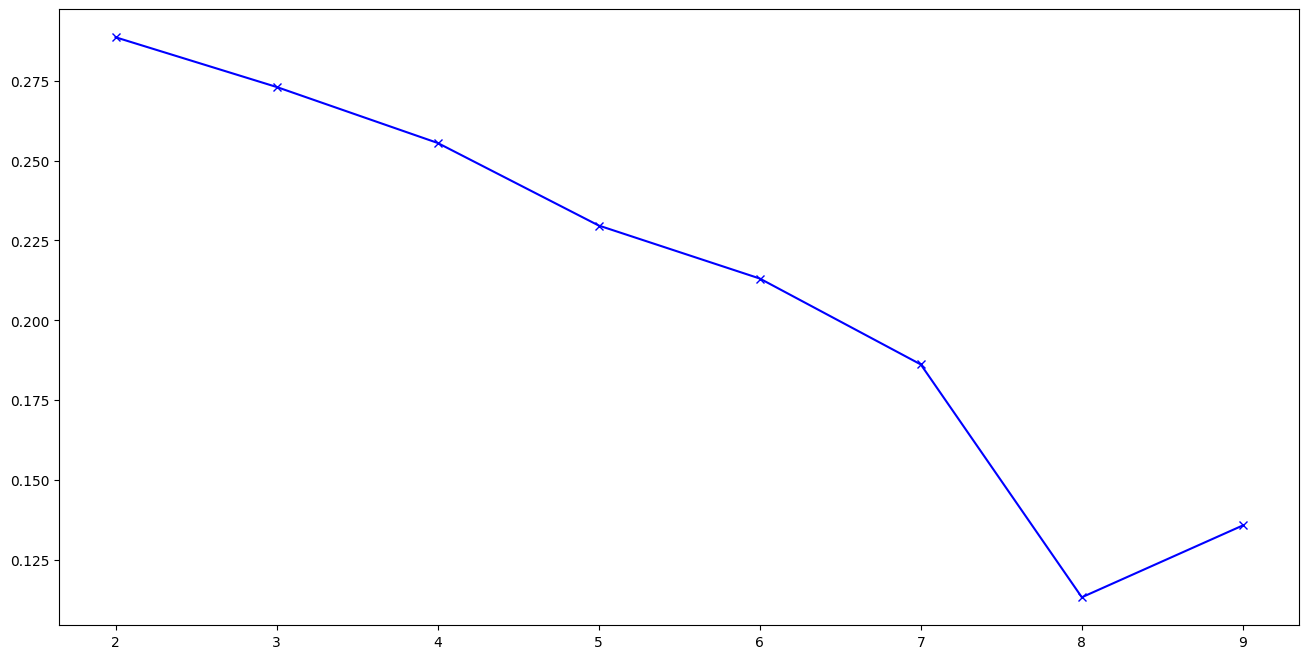

In [143]:
%matplotlib inline
plt.figure(figsize=(16,8))
plt.plot(K, sil, 'bx-')
plt.show()

In [148]:
k = max(K[sil.index(max(sil))], 5)
kmeans = KMeans(n_clusters=k, random_state=0).fit(docvecs)
labels = kmeans.labels_
print('%d clusters' % k)

5 clusters


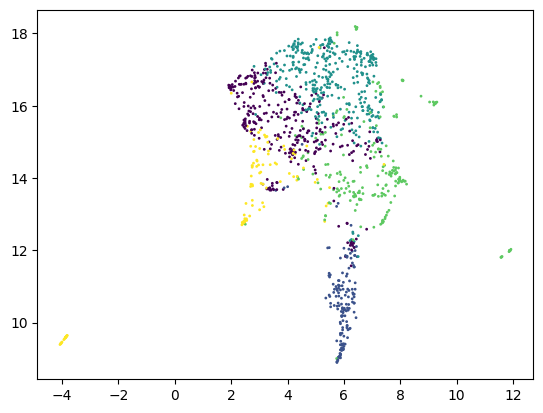

In [149]:
#pred = kmeans.fit_predict(embedding)
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    s=1,
    c=labels)

In [150]:
cluster_centers = [sum([docvecs[i] for i in range(len(docvecs)) if labels[i] == j]) for j in range(k)]
cluster_centers = [v/norm(v) for v in cluster_centers]

#v0 /= norm(v0)
#model.most_similar(v0)

In [151]:
from nltk.corpus import wordnet as wn
all_nouns = [word for synset in wn.all_synsets('n') for word in synset.lemma_names()]

In [156]:
[w for w in model.most_similar(cluster_centers[4], topn = 200) if not w[0] in stopwords and w[0] in all_nouns][:10]

[('tax', 0.5424684882164001),
 ('income', 0.4963119328022003),
 ('revenue', 0.48781758546829224),
 ('savings', 0.48625147342681885),
 ('budget', 0.4717312753200531),
 ('cost', 0.46817901730537415),
 ('billion', 0.46434494853019714),
 ('expenditure', 0.46411341428756714),
 ('pay', 0.4637846350669861),
 ('increase', 0.4567382335662842)]

In [157]:
cl = 0
print(np.where(labels==cl)[0].shape[0])
D = [data[i] for i in range(len(data)) if labels[i] == cl]
print(len([x for x in D if 'gamb' in x])/len(D))

317
0.0


In [158]:
D[:8]

['i completely agree with the hon gentleman i see no reason to maintain a cap if we have conceded the principle that leaseholders are not to blame that developers have made a lot of money out of these developments and that there is money available for the government to go after on behalf of taxpayers all over the country they should do so and they should protect leaseholders from any additional costs i am concerned that the building safety fund still adopts a  computer says no approach in cases such as those of islington gates where eligibility for the fund has been accepted the works are under way and the initial payment has been made administrative errors can lead to delays in further payments for the works and that causes a huge amount of unnecessary stress people are putting up with living in buildings that are completely covered and have no natural light they are putting up with living inside a building site so they have all the noise and dust of that and the general loss of norma

In [159]:
from rake_nltk import Rake
rake_nltk_var = Rake()
rake_nltk_var.extract_keywords_from_text(' '.join(data))

In [160]:
keywords = rake_nltk_var.get_ranked_phrases_with_scores()

In [161]:
keywords

[(64.0, 'almamo jammeh ousmane diaby bangally dukureh saibo sillah'),
 (61.448109669687966, '-[ official report 29 june 1983 vol 44 c 623'),
 (53.880787562948036,
  'around 65 000 open cases involving marketed tax avoidance schemes representing potentially billions'),
 (48.48652052240114, 'official report 28 january 1992 vol 202 c 808'),
 (47.9585679206761, 'official report 5 december 2013 vol 571 c 1107'),
 (47.565480561706735, 'official report 13 june 1991 vol 192 c 627w'),
 (47.4947494546342, 'official report 22 june 2010 vol 512 c 177'),
 (47.251888373462464, 'official report 19 march 2014 vol 577 c 781'),
 (47.11746743911152, 'official report 21 november 2017 vol 631 c 839'),
 (45.72697623497035,
  'hm treasury press release chancellor announces £ 4 5 billion'),
 (45.72697623497035,
  'hm treasury press release chancellor announces £ 4 5 billion'),
 (45.72697623497035,
  'hm treasury press release chancellor announces £ 4 5 billion'),
 (45.72697623497035,
  'hm treasury press rele

## experiments with optics

In [187]:
from sklearn.cluster import OPTICS, cluster_optics_dbscan
clust = OPTICS(min_samples=50, xi=0.05, min_cluster_size=0.05).fit(docvecs)

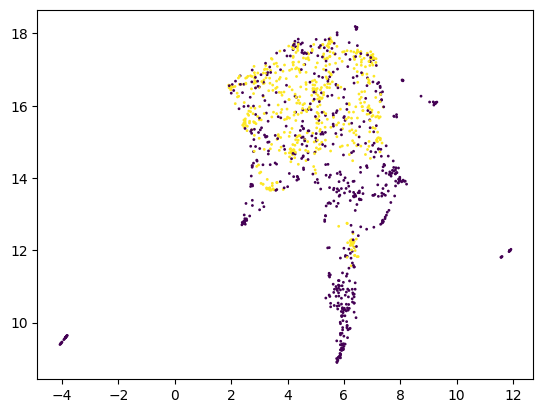

In [188]:
from sklearn.cluster import OPTICS, cluster_optics_dbscan
labels_050 = cluster_optics_dbscan(
    reachability=clust.reachability_,
    core_distances=clust.core_distances_,
    ordering=clust.ordering_,
    eps=0.5,
)
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    s=1,
    c=labels_050)

0


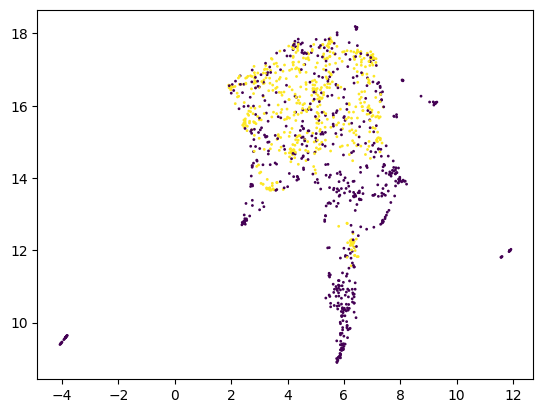

In [189]:
from sklearn.cluster import OPTICS, cluster_optics_dbscan
labels_020 = cluster_optics_dbscan(
    reachability=clust.reachability_,
    core_distances=clust.core_distances_,
    ordering=clust.ordering_,
    eps=0.5,
)
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    s=1,
    c=labels_020)
print(max(labels_020))

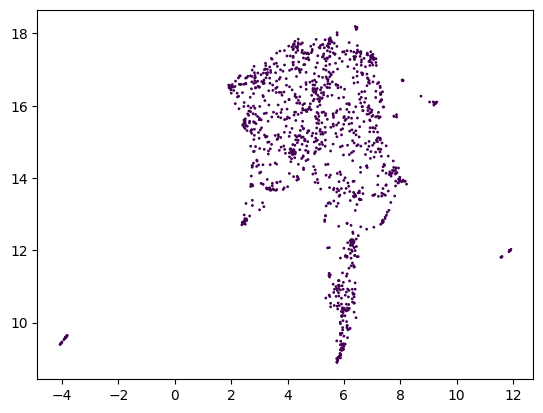

In [190]:
labels_200 = cluster_optics_dbscan(
    reachability=clust.reachability_,
    core_distances=clust.core_distances_,
    ordering=clust.ordering_,
    eps=2,
)
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    s=1,
    c=labels_200)

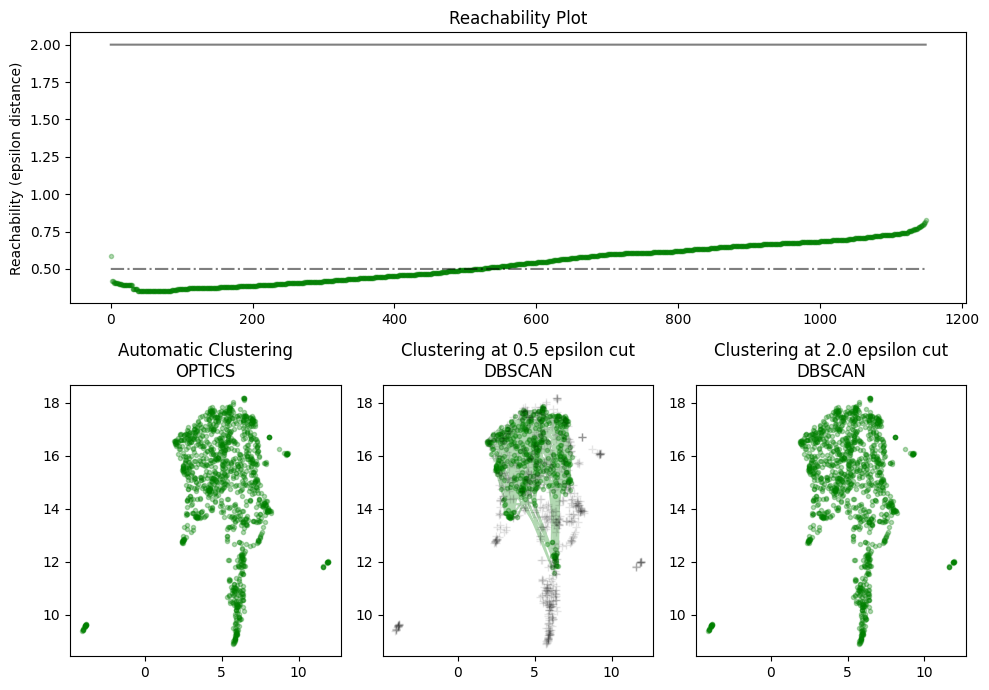

In [191]:
import matplotlib.gridspec as gridspec
X = embedding
space = np.arange(len(X))
reachability = clust.reachability_[clust.ordering_]
labels = clust.labels_[clust.ordering_]

plt.figure(figsize=(10, 7))
G = gridspec.GridSpec(2, 3)
ax1 = plt.subplot(G[0, :])
ax2 = plt.subplot(G[1, 0])
ax3 = plt.subplot(G[1, 1])
ax4 = plt.subplot(G[1, 2])

# Reachability plot
colors = ["g.", "r.", "b.", "y.", "c."]
for klass, color in zip(range(0, 5), colors):
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    ax1.plot(Xk, Rk, color, alpha=0.3)
ax1.plot(space[labels == -1], reachability[labels == -1], "k.", alpha=0.3)
ax1.plot(space, np.full_like(space, 2.0, dtype=float), "k-", alpha=0.5)
ax1.plot(space, np.full_like(space, 0.5, dtype=float), "k-.", alpha=0.5)
ax1.set_ylabel("Reachability (epsilon distance)")
ax1.set_title("Reachability Plot")

# OPTICS
colors = ["g.", "r.", "b.", "y.", "c."]
for klass, color in zip(range(0, 5), colors):
    Xk = X[clust.labels_ == klass]
    ax2.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax2.plot(X[clust.labels_ == -1, 0], X[clust.labels_ == -1, 1], "k+", alpha=0.1)
ax2.set_title("Automatic Clustering\nOPTICS")

# DBSCAN at 0.5
colors = ["g", "greenyellow", "olive", "r", "b", "c"]
for klass, color in zip(range(0, 6), colors):
    Xk = X[labels_050 == klass]
    ax3.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3, marker=".")
ax3.plot(X[labels_050 == -1, 0], X[labels_050 == -1, 1], "k+", alpha=0.1)
ax3.set_title("Clustering at 0.5 epsilon cut\nDBSCAN")

# DBSCAN at 2.
colors = ["g.", "m.", "y.", "c."]
for klass, color in zip(range(0, 4), colors):
    Xk = X[labels_200 == klass]
    ax4.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax4.plot(X[labels_200 == -1, 0], X[labels_200 == -1, 1], "k+", alpha=0.1)
ax4.set_title("Clustering at 2.0 epsilon cut\nDBSCAN")

plt.tight_layout()
plt.show()

In [192]:
k = max(labels_050) + 1
print(k)
cluster_centers = [sum([docvecs[i] for i in range(len(docvecs)) if labels[i] == j]) for j in range(k)]
cluster_centers = [v/norm(v) for v in cluster_centers]


1


In [179]:
[w for w in model.most_similar(cluster_centers[0], topn = 200) if not w[0] in stopwords and w[0] in all_nouns][:10]

[('education', 0.4663327634334564),
 ('business', 0.44797635078430176),
 ('work', 0.44665268063545227),
 ('necessary', 0.43794190883636475),
 ('means', 0.4323490858078003),
 ('services', 0.42593449354171753),
 ('time', 0.4191371500492096),
 ('employment', 0.4179142415523529),
 ('policy', 0.41479796171188354),
 ('come', 0.41436702013015747)]